# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных:**

Данные геологоразведки трёх регионов находятся в файлах: 
1) `geo_data_0.csv` 
2) `geo_data_1.csv` 
3) `geo_data_2.csv`

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [88]:
!pip install phik -q

In [89]:
import time
start_time = time.time()

import os
import numpy as np
import pandas  as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import phik
from phik import phik_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
from sklearn.exceptions import FitFailedWarning 


from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (RandomizedSearchCV,
                                     train_test_split
                                    )
from sklearn.preprocessing import (MinMaxScaler,
                                   RobustScaler,
                                   StandardScaler
                                  )
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

### Подготовка данных `geo_data_0.csv`

In [90]:
pth1 = '/datasets/geo_data_0.csv'

geo_data_0 = pd.read_csv(pth1, index_col='id')
geo_data_0.head(10)

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647
wX4Hy,0.969570,0.489775,-0.735383,64.741541
tL6pL,0.645075,0.530656,1.780266,49.055285
BYPU6,-0.400648,0.808337,-5.624670,72.943292
j9Oui,0.643105,-0.551583,2.372141,113.356160


### Подготовка данных `geo_data_1.csv`

In [91]:
pth1 = '/datasets/geo_data_1.csv'

geo_data_1 = pd.read_csv(pth1, index_col='id')
geo_data_1.head(10)

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305
HHckp,-3.327590,-2.205276,3.003647,84.038886
h5Ujo,-11.142655,-10.133399,4.002382,110.992147
muH9x,4.234715,-0.001354,2.004588,53.906522
YiRkx,13.355129,-0.332068,4.998647,134.766305


### Подготовка данных `geo_data_2.csv`

In [92]:
pth1 = '/datasets/geo_data_2.csv'

geo_data_2 = pd.read_csv(pth1, index_col='id')
geo_data_2.head(10)

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746
LzZXx,-0.758092,0.710691,2.585887,90.222465
WBHRv,-0.574891,0.317727,1.773745,45.641478
XO8fn,-1.906649,-2.458350,-0.177097,72.480640
ybmQ5,1.776292,-0.279356,3.004156,106.616832


### Предобработка данных

In [93]:
geo_data_0.drop_duplicates().info()
geo_data_1.drop_duplicates().info()
geo_data_2.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1  

In [94]:
print('Количество перекрестных совпадений "id" в  таблицах 0 и 1 = ', len(geo_data_0[geo_data_0.index.isin(geo_data_1.index.unique())]))
print('Количество перекрестных совпадений "id" в  таблицах 0 и 2 = ', len(geo_data_0[geo_data_0.index.isin(geo_data_2.index.unique())]))
print('Количество перекрестных совпадений "id" в  таблицах 1 и 2 = ', len(geo_data_1[geo_data_1.index.isin(geo_data_2.index.unique())]))

Количество перекрестных совпадений "id" в  таблицах 0 и 1 =  10
Количество перекрестных совпадений "id" в  таблицах 0 и 2 =  17
Количество перекрестных совпадений "id" в  таблицах 1 и 2 =  4


**Вывод по обработке**

Данные не содержат пропусков, а их типы соответствуют содержанию. Пока мы оставим без изменений совпадающие индексы скважин в разных регионах. Далее перейдём к проведению исследовательского анализа.

### Исследовательский анализ данных

In [95]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [96]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [97]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


В исследовательском анализе данных согласно датасету нас ждут 4 параметра:
 - `f0`
 - `f1`
 - `f2`
 - `product`
 
Известное, что `f0`, `f1`, `f2` — три признака точек. А `product` — объём запасов в скважине

Исследование параметра `f0`

In [98]:
def f_hist_box_1(hb1, bins, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,5), gridspec_kw={"height_ratios": (.15, .85)})
     
    sns.boxplot(data=[hb1], orient="h", ax=ax_box)
    plt.hist([hb1], 
             bins=bins, range=(hb1.min(), hb1.max()), label=hb1.name)
 
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

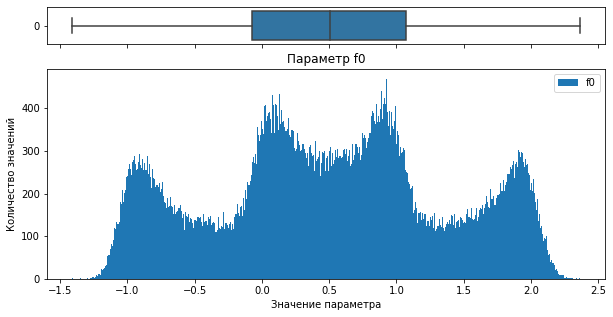

In [99]:
f_hist_box_1(
    hb1=geo_data_0['f0'],
    bins=500,
        title='Параметр f0',
    xlabel='Значение параметра',
    ylabel='Количество значений',
)

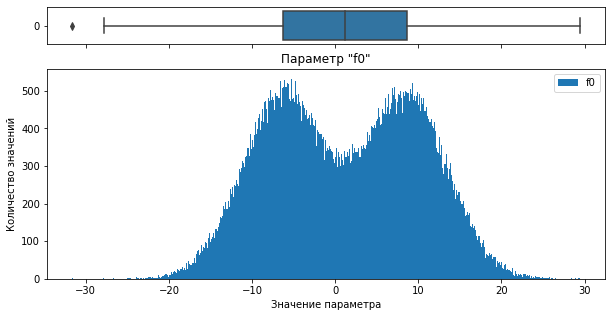

In [100]:
f_hist_box_1(
    hb1=geo_data_1['f0'],
    bins=500,   
    title='Параметр "f0"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

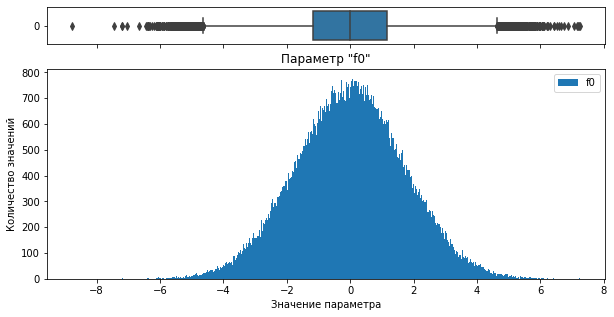

In [101]:
f_hist_box_1(
    hb1=geo_data_2['f0'],
    bins=500,   
    title='Параметр "f0"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Сопоставим данные

In [102]:
def f_hist_box_3(hb1, hb2, hb3, bins, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,5), gridspec_kw={"height_ratios": (.15, .85)})
     
    sns.boxplot(data=[hb1, hb2, hb3], orient="h", ax=ax_box)
    plt.hist([hb1, hb2, hb3], 
             bins=bins, range=(min(hb1.min(), hb2.min(), hb3.min()), max(hb1.max(), hb2.max(), hb3.max())), 
             label=['geo_data_0', 'geo_data_1', 'geo_data_2'])
 
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

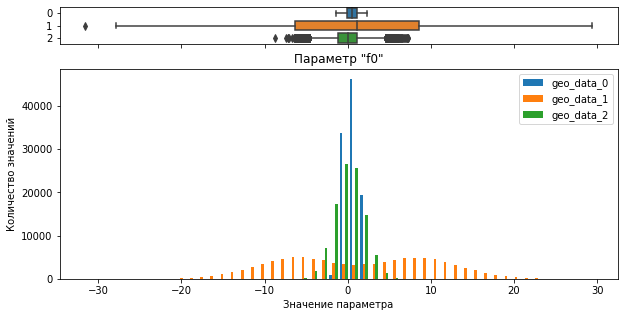

In [103]:
f_hist_box_3(
    hb1=geo_data_0['f0'],
    hb2=geo_data_1['f0'],
    hb3=geo_data_2['f0'],
    bins=50,
    title='Параметр "f0"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Далее исследуем параметр `f1`

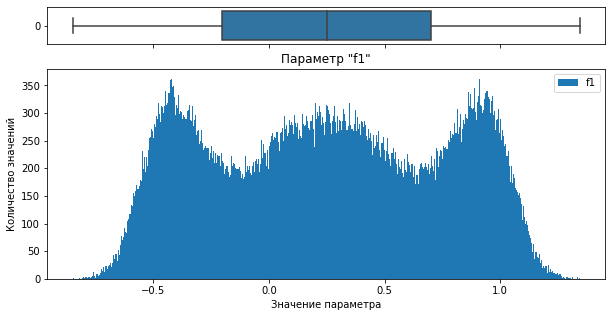

In [104]:
f_hist_box_1(
    hb1=geo_data_0['f1'],
    bins=500,   
    title='Параметр "f1"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

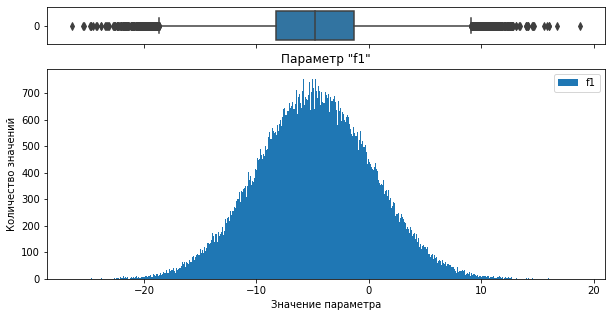

In [105]:
f_hist_box_1(
    hb1=geo_data_1['f1'],
    bins=500,   
    title='Параметр "f1"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

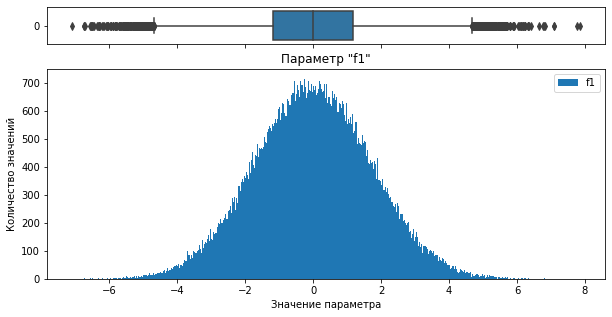

In [106]:
f_hist_box_1(
    hb1=geo_data_2['f1'],
    bins=500,   
    title='Параметр "f1"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Сопоставим данные

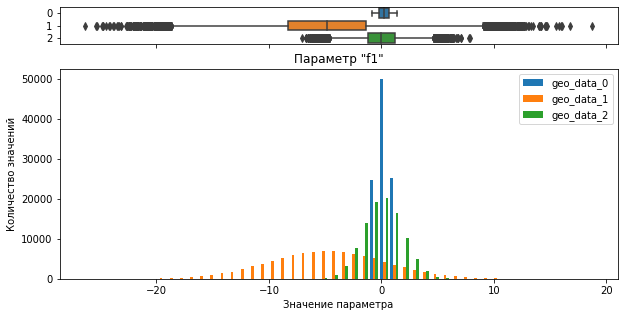

In [107]:
f_hist_box_3(
    hb1=geo_data_0['f1'],
    hb2=geo_data_1['f1'],
    hb3=geo_data_2['f1'],
    bins=50,
    title='Параметр "f1"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Исследование параметра `f2`

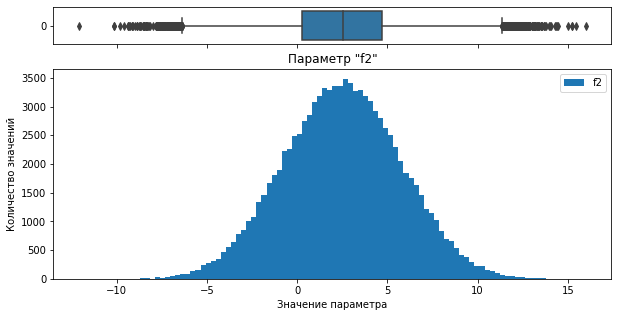

In [108]:
f_hist_box_1(
    hb1=geo_data_0['f2'],
    bins=100,   
    title='Параметр "f2"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

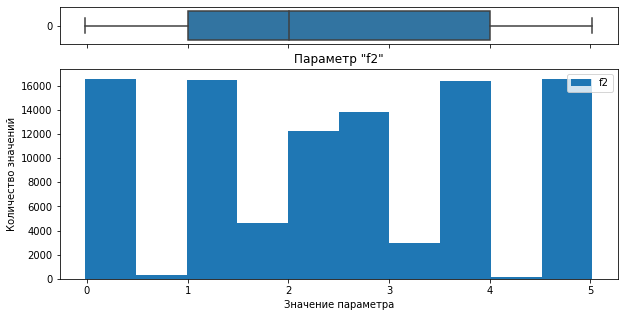

In [109]:
f_hist_box_1(
    hb1=geo_data_1['f2'],
    bins=10,   
    title='Параметр "f2"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

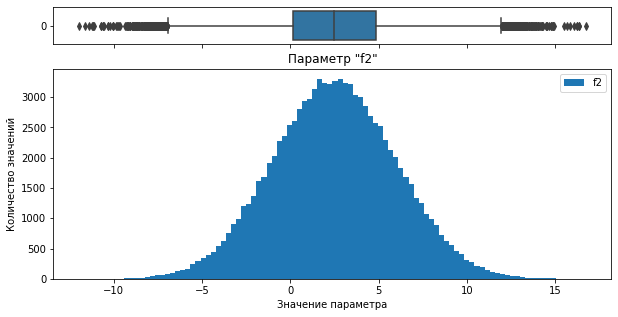

In [110]:
f_hist_box_1(
    hb1=geo_data_2['f2'],
    bins=100,   
    title='Параметр "f2"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Сопоставим данных

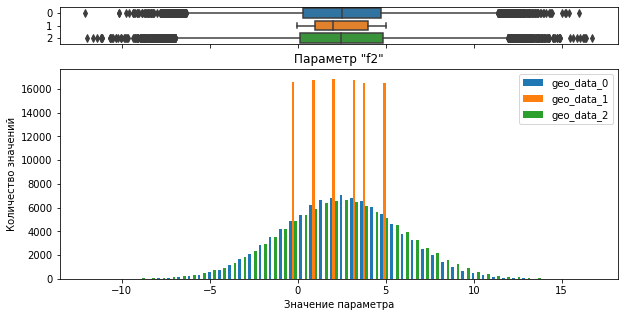

In [111]:
f_hist_box_3(
    hb1=geo_data_0['f2'],
    hb2=geo_data_1['f2'],
    hb3=geo_data_2['f2'],
    bins=50,
    title='Параметр "f2"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Исследование параметра `product`

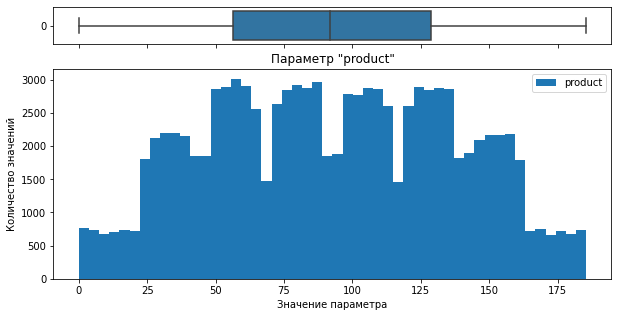

In [112]:
f_hist_box_1(
    hb1=geo_data_0['product'],
    bins=50,   
    title='Параметр "product"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

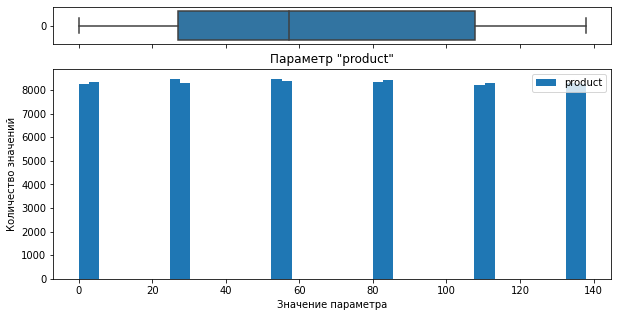

In [113]:
f_hist_box_1(
    hb1=geo_data_1['product'],
    bins=50,   
    title='Параметр "product"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

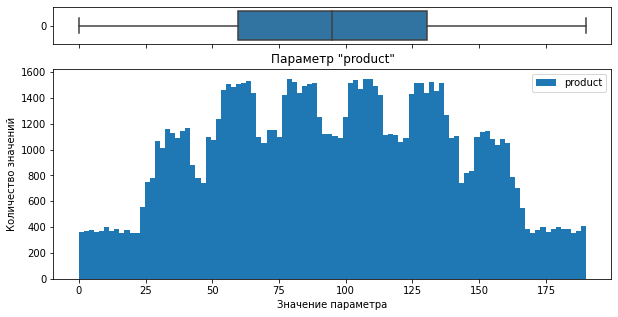

In [114]:
f_hist_box_1(
    hb1=geo_data_2['product'],
    bins=100,   
    title='Параметр "product"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

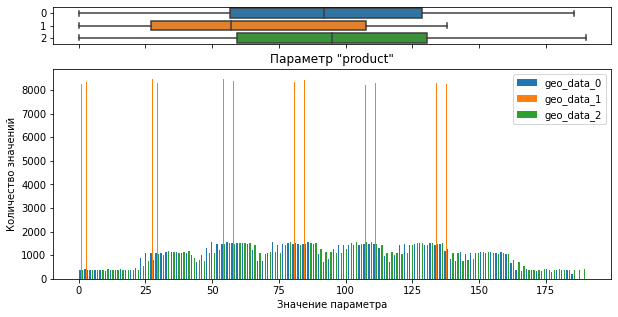

In [115]:
f_hist_box_3(
    hb1=geo_data_0['product'],
    hb2=geo_data_1['product'],
    hb3=geo_data_2['product'],
    bins=100,
    title='Параметр "product"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

**Выводы по исследовательскому анализу данных**

В наборе данных выявлено значительное количество выбросов, при этом отклонения от медианы распределены довольно равномерно.
А также показатели по различным регионам демонстрируют существенные различия по всем измеряемым характеристикам.

Далее проведем корреляционный анализ данных.

### Корреляционный анализ данных

Корреляция данных `geo_data_0`

In [116]:
interval_cols = ['f0', 
                 'f1', 
                 'f2', 
                 'product'
                ]

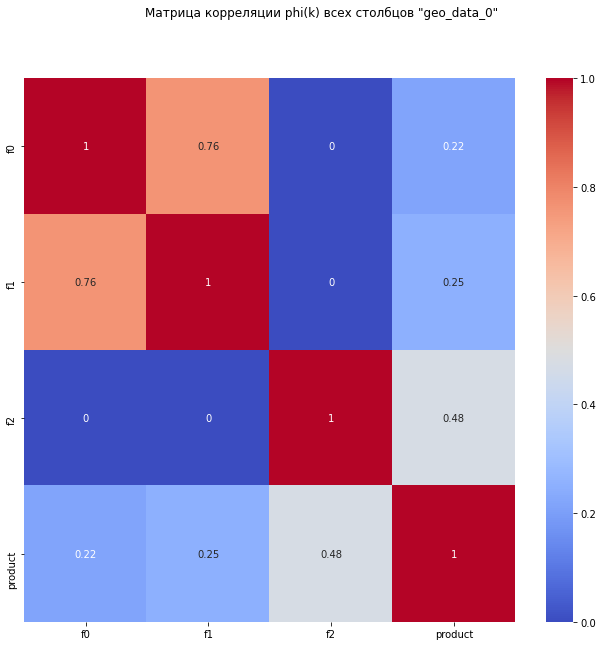

In [117]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "geo_data_0"')
sns.heatmap(geo_data_0.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Корреляция данных `geo_data_1`

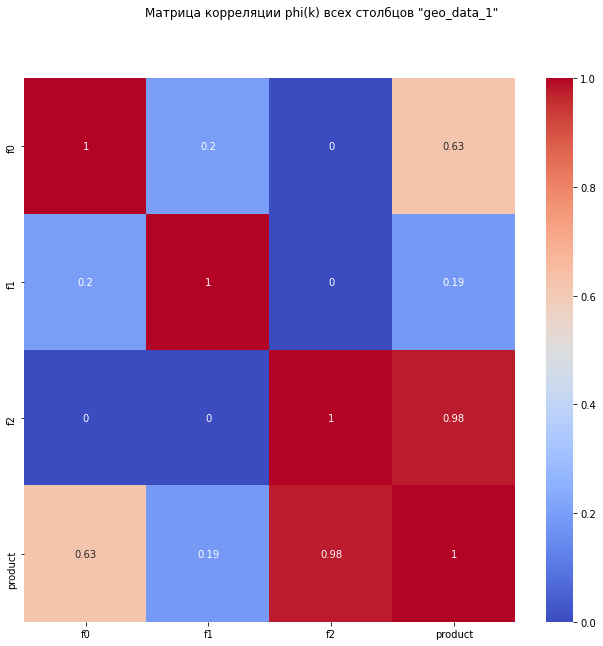

In [118]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "geo_data_1"')
sns.heatmap(geo_data_1.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Корреляция данных `geo_data_2`

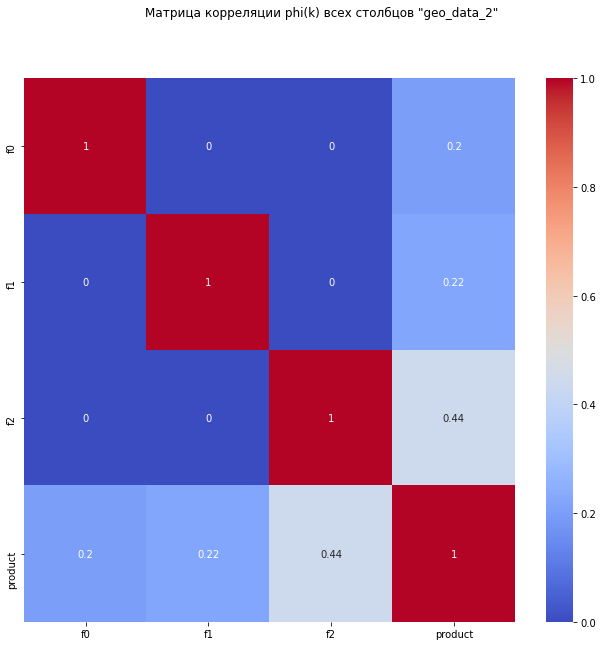

In [119]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "geo_data_2"')
sns.heatmap(geo_data_2.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

**Вывод по корреляционному аналиу данных**

Мы выполнили корреляционный анализ данных и получили следующие результаты:

- В данных выявлены выбросы, однако отклонения от медианы распределены примерно равномерно.
- Между входными параметрами данных по всем регионам не обнаружено связи с коэффициентом выше 0,9. Это означает, что при обучении модели нет необходимости учитывать мультиколлинеарность. В анализе использовался коэффициент корреляции phi(k), который учитывает нелинейную зависимость и при бинарном нормальном распределении входных данных возвращается к коэффициенту корреляции Пирсона.
- В данных `geo_data_1` обнаружена прямая зависимость между входным параметром `f2` и целевым признаком `product` (phi(k) = 0,98).
- Значения корреляции между признаками и целевым показателем различаются по регионам.

Теперь можно приступить к следующей задаче, а именно обучению и проверке модели

## Обучение и проверка модели

Согласно условиям задачи, для обучения модели целесообразно использовать только линейную регрессию, поскольку другие методы демонстрируют недостаточную предсказуемость.

In [120]:
RANDOM_STATE = 42

names = ['geo_predict_0', 'geo_predict_1', 'geo_predict_2']
data = [geo_data_0, geo_data_1, geo_data_2]
targets_1 = {}
targets = {}

for name, data in zip(names, data):
    
    X = data.drop(columns='product')
    y = data['product']

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
        random_state=RANDOM_STATE
    )
    
    param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(), 
                              'passthrough']   
    },

    ]
    
    num_columns = ['f0', 'f1', 'f2']
    data_preprocessor = ColumnTransformer(
    [('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
    )


    pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
    ])

    rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
    )

    rs.fit(X_train, y_train)
    
    targets_1[name] =  pd.concat([pd.DataFrame(y).reset_index(), pd.DataFrame(data=rs.predict(X), columns=['predict'])], axis=1)
    
    targets[name] =  pd.concat([pd.DataFrame(y_test).reset_index(), pd.DataFrame(data=rs.predict(X_test), columns=['predict'])], axis=1)
    print('//////////')
    print(f'Для данных "{name}" выборка поделена на `Обучающую:Валидационную` в размере {X_train.shape[0]/X.shape[0]}:{X_test.shape[0]/X.shape[0]}')
    print('----------')
    print(f'Метрика лучшей модели на на кросс-валидации:{(abs(rs.best_score_)**0.5):.3f}')
    print('----------')
    rmse_train = (mean_squared_error(y_train, rs.predict(X_train)))**0.5
    print(f'Значение RMSE  на обучающей выборке: {rmse_train:.3f}')
    rmse_test = (mean_squared_error(y_test, rs.predict(X_test)))**0.5
    print(f'Значение RMSE  на тестовой выборке: {rmse_test:.3f}')
    print('----------')
    print(f'Средний запас фактического сырья по валидационной выборке = {y_test.mean():.2f} тыс. баррелей')
    print(f'Средний запас предсказанного сырья по валидационной выборке = {rs.predict(X_test).mean():.2f} тыс. баррелей')
    print(f'Разница = {(1-y_test.mean().mean()/rs.predict(X_test).mean()):.2%}')    

//////////
Для данных "geo_predict_0" выборка поделена на `Обучающую:Валидационную` в размере 0.75:0.25
----------
Метрика лучшей модели на на кросс-валидации:37.673
----------
Значение RMSE  на обучающей выборке: 37.670
Значение RMSE  на тестовой выборке: 37.757
----------
Средний запас фактического сырья по валидационной выборке = 92.33 тыс. баррелей
Средний запас предсказанного сырья по валидационной выборке = 92.40 тыс. баррелей
Разница = 0.08%
//////////
Для данных "geo_predict_1" выборка поделена на `Обучающую:Валидационную` в размере 0.75:0.25
----------
Метрика лучшей модели на на кросс-валидации:0.890
----------
Значение RMSE  на обучающей выборке: 0.890
Значение RMSE  на тестовой выборке: 0.890
----------
Средний запас фактического сырья по валидационной выборке = 68.73 тыс. баррелей
Средний запас предсказанного сырья по валидационной выборке = 68.71 тыс. баррелей
Разница = -0.02%
//////////
Для данных "geo_predict_2" выборка поделена на `Обучающую:Валидационную` в размере 0.

**Вывод по главе 2**

В ходе обучения и проверки модели были выполнены следующие шаги:
- Данные были разделены на обучающую и валидационную выборки в соотношении 75% к 25%.
- Модель была обучена, после чего были сделаны прогнозы на валидационной выборке.
- Предсказания и правильные ответы для валидационной выборки были сохранены в `targets`.
- Был рассчитан средний запас предсказанного сырья на валидационной выборке.
- Определено значение RMSE для модели.

Анализ результатов показал следующее:
RMSE (корень из среднеквадратичной ошибки) для данных `geo_predict_1` составляет 0,890, а для `geo_predict_0` и `geo_predict_2` — 37,757 и 40,146 соответственно. Это указывает на значительный разброс данных и отсутствие прямой связи между входными параметрами и целевым показателем, что подтверждается ранее проведённым корреляционным анализом. Следовательно, предсказанные значения не отражают реальные запасы сырья с высокой точностью.

## Подготовка к расчёту прибыли

Для расчета прибыли сохраним ключевые значения для расчетов в отдельные переменные, где:
- `POINTS` - количество скважин, которое исследуют при разведке региона;
- `BEST_POINTS` - количество лучших скважин, которые нужно выбрать для разработки в каждом регионе с помощью машинного обучения;
- `BUDGET` - бюджет (расходы) на разработку скважин в регионе (тыс. рублей), заложенный на 200 скважин;
- `BARREL_PRICE` - доход с каждой единицы продукта (тыс. рублей на 1 тыс. баррелей);
- `LIMIT` - предел вероятности убытков меньше

In [121]:
POINTS = 500 
BEST_POINTS = 200 
BUDGET = 10e9
BARREL_PRICE = 450_000
LIMIT = 0.025

Теперь мы можем определить необходимый объём сырья, который обеспечит безубыточную эксплуатацию новой скважины.

In [122]:
names = ["geo_predict_0", "geo_predict_1", "geo_predict_2"]
data = [geo_data_0, geo_data_1, geo_data_2]

break_even = BUDGET / (BARREL_PRICE * BEST_POINTS)
print(f'Достаточный объём сырья для безубыточной разработки = {break_even:.2f} тыс. баррелей.')

for name, data in zip(names, data):
    print()
    print(f'Средний запас в {name} регионе = {data["product"].mean():.2f} тыс. баррелей.')
    
    print(f'Количество скважин c объёмом больше {break_even:.2f} тыс. баррелей по исходным данным = \
{len(targets_1[name].query("product > @break_even"))} или \
{len(targets_1[name].query("product > @break_even")) / len(targets_1[name]):.2%}')

    print(f'Количество скважин c объёмом больше {break_even:.2f} тыс. баррелей по предсказанным данным = \
{len(targets_1[name].query("predict > @break_even"))} или \
{len(targets_1[name].query("predict > @break_even")) / len(targets_1[name]):.2%}')
    
    print(f'Количество скважин c объёмом больше {break_even:.2f} тыс. баррелей по верификационным данным = \
{len(targets[name].query("predict > @break_even"))} или \
{len(targets[name].query("predict > @break_even")) / len(targets[name]):.2%}')


Достаточный объём сырья для безубыточной разработки = 111.11 тыс. баррелей.

Средний запас в geo_predict_0 регионе = 92.50 тыс. баррелей.
Количество скважин c объёмом больше 111.11 тыс. баррелей по исходным данным = 36583 или 36.58%
Количество скважин c объёмом больше 111.11 тыс. баррелей по предсказанным данным = 21471 или 21.47%
Количество скважин c объёмом больше 111.11 тыс. баррелей по верификационным данным = 5258 или 21.03%

Средний запас в geo_predict_1 регионе = 68.83 тыс. баррелей.
Количество скважин c объёмом больше 111.11 тыс. баррелей по исходным данным = 16537 или 16.54%
Количество скважин c объёмом больше 111.11 тыс. баррелей по предсказанным данным = 18185 или 18.19%
Количество скважин c объёмом больше 111.11 тыс. баррелей по верификационным данным = 4520 или 18.08%

Средний запас в geo_predict_2 регионе = 95.00 тыс. баррелей.
Количество скважин c объёмом больше 111.11 тыс. баррелей по исходным данным = 38178 или 38.18%
Количество скважин c объёмом больше 111.11 тыс. бар

**Вывод по главе 3**

- Все необходимые для вычислений данные были сохранены в отдельных переменных.
- Чтобы разработка скважины была безубыточной, объём сырья должен составлять 111,11 тыс. баррелей. Это существенно больше средних запасов по всем регионам, что может привести к финансовым потерям при ошибочном выборе скважин для разработки.

## Расчёт прибыли и рисков 

Функция, предназначенная для вычисления прибыли на основе выбранных скважин и прогнозов модели, должна выполнять следующие действия:
- выбирать скважины с наибольшими прогнозируемыми значениями;
- суммировать целевые объёмы сырья, соответствующие выбранным прогнозам;
- рассчитывать прибыль на основе полученного суммарного объёма сырья.

### Подготовим функцию расчёта прибыли

In [131]:
def f_profit(product_sample, predict_sample, count):
    # Сбрасываем индексы для обоих сэмплов
    product_sample.reset_index(drop=True, inplace=True)
    predict_sample.reset_index(drop=True, inplace=True)
    
    # Удаляем дубликаты индексов (теперь они гарантированно уникальны)
    predict_sample = predict_sample[~predict_sample.index.duplicated()]
    
    # Сортируем предсказания и выбираем топ-N
    predictions_sorted = predict_sample.sort_values(ascending=False)[:count] #предсказанные запасы нефти
    
    # Выбираем соответствующие скважины и считаем прибыль
    selected = product_sample[predictions_sorted.index]
    
    # КОД РЕВЬЮЕРА
    if selected.shape[0] != 200:
        print(f"Не исправлено, взято таргетов {selected.shape[0]}")

    return selected.sum() * BARREL_PRICE - BUDGET

Функция расчета прибыли подготовлена:
- Прогнозный семплированный объем, отсортирован и срезан по  ограничению количества скважин;
- Отобраны разведанные объемы по  предыдущему срезу;
- Суммарный объем скважин умножен на стоимость барреля за вычетом вложенного бюджета.

Перейдем к подсчету рисков

### Посчитаем риски и прибыль для каждого региона

----------
Для региона: geo_predict_0 риск 6.70% > 2.50% 
----------


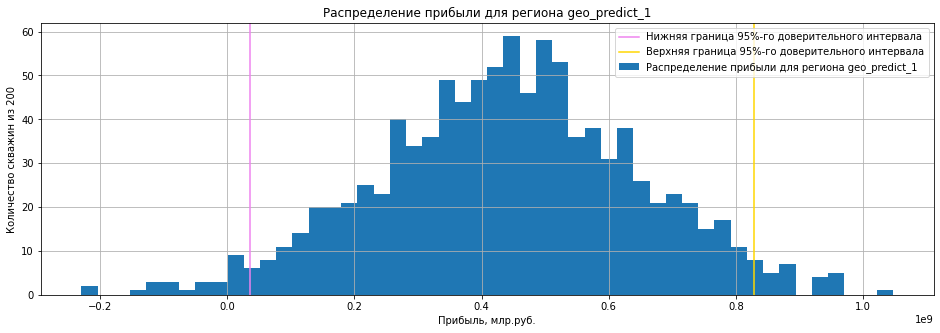


Для geo_predict_1 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 442 млн. рублей.
Доверительный интервал лежит между 36 - 828 млн. рублей.
Риск убытков составляет = 1.60%
----------
Для региона: geo_predict_2 риск 7.80% > 2.50% 
----------


In [132]:
STATE = np.random.RandomState(12345)

for name in names:
    values = []
    for i in range(1000):
        product_sample = targets[name]['product'].sample(POINTS, replace=True, random_state=STATE)
        predict_sample = targets[name]['predict'][product_sample.index]
        if product_sample is not None and predict_sample is not None:
            values.append(f_profit(product_sample, predict_sample, BEST_POINTS))
        
    values = pd.Series(values)
     
    mean = values.mean() / 1_000_000
    lower = values.quantile(0.025) / 1_000_000
    upper = values.quantile(0.975) / 1_000_000
    
    risk = values.apply(lambda x: x < 0).sum() / len(values)
    if risk > LIMIT:
        print('----------')
        print(f'Для региона: {name} риск {risk:.2%} > {LIMIT:.2%} ')
        print('----------')
        continue
    
    # визуализируем
    values.hist(figsize=(16, 5), bins=50)
    plt.grid(True)
    plt.axvline(values.quantile(0.025), color='violet')
    plt.axvline(values.quantile(0.975), color='gold')
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
                'Верхняя граница 95%-го доверительного интервала', f'Распределение прибыли для региона {name}'])
    plt.xlabel('Прибыль, млр.руб.')
    plt.ylabel('Количество скважин из 200')
    plt.title(f'Распределение прибыли для региона {name}')
    plt.show()

    print()
    print(f'Для {name} региона:')
    print(f'Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = {mean:.0f} млн. рублей.')
    print(f'Доверительный интервал лежит между {lower:.0f} - {upper:.0f} млн. рублей.')
    print(f'Риск убытков составляет = {risk:.2%}')

**Вывод по главе 5**

Для анализа распределения прибыли использовали метод Bootstrap, проведя 1000 итераций со случайным выбором 500 скважин в каждом регионе на основе предсказанных данных. Из отобранных скважин выбирали 200 с наибольшим запасом и рассчитывали распределение прибыли.

Также вычислили среднюю прибыль по регионам при случайном отборе 500 скважин и определили риск возникновения убытков при таком подходе. Для каждого региона рассчитали 95%-й доверительный интервал при случайном выборе 500 скважин.

Затем отобрали регионы, где риск убытков был меньше 2,5%, и построили гистограмму распределения прибыли для одного из них при случайном отборе 500 скважин.

После оценки рисков наиболее перспективным регионом для разработки оказался `geo_predict_1`. В этом регионе вероятность убытков составляет менее 2,5%, средняя прибыль — 442 млн рублей, доверительный интервал — от 36 до 828 млн рублей, а риск возникновения убытков — всего 1,60%

## Общий вывод по работе

На основании проведённого анализа рекомендуется выбрать для разработки регион с данными `geo_predict_1`. Риск возникновения убытков в этом регионе составляет всего 0,60% при случайном выборе 500 скважин и отборе из них 200 лучших, что значительно ниже допустимого уровня в 2,5%. Средняя прибыль по региону оценивается в 516 млн рублей при 95% доверительном интервале от 89 до 928 млн рублей. Для минимизации рисков и повышения прибыли предлагается отбирать для разработки скважины с разведанным запасом нефти более 111,11 тыс. баррелей.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован